### Using a Variational Auto-encoder to predict protein fitness from evolutionary data

July 20, 2017
### Sam Sinai and Eric Kelsic


## For the blog post associated with this notebook see [this post](https://samsinai.github.io/jekyll/update/2017/08/14/Using-a-Variational-Autoencoder-to-predict-protein-function.html). 


This notebook it organized in 3 sections. In section 1 we show our workflow for pre-processing the biological data. We then train the model on the alignment data in section 2. In section 3 we compare the predictions of the model on the [PABP yeast](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3851721/) dataset. In section 4 we report the results from analyzing multiple other datasets. Finally we pose some questions with regards to improving the model for interested researcher.

In [1]:
# Generic imports
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math,random,re
import time

In [2]:
#Machine learning/Stats imports 
from scipy.stats import norm
from scipy.stats import spearmanr,pearsonr
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributions as D

In [11]:
from models import *

## 1.  Data pre-processing

Defining the alphabet that is used for Amino-Acids throughout.

These are helper functions to clean and process data. 

In [12]:
%reload_ext autoreload
%autoreload 1
from helper_tools import *
from helper_tools_for_plotting import *

Import the alignment data:

In [114]:
# # data=pdataframe_from_alignment_file("PABP_YEAST_hmmerbit_plmc_n5_m30_f50_t0.2_r115-210_id100_b48.a2m",50000)
data_sar=pd.read_csv("sarkisyan.csv")
# print ("number of data points: ",len(data))
# data_set_size=len(data)
# data.head()

In [115]:
from Bio import SeqIO
seqs = []
for record in SeqIO.parse("aligned_gfp.fasta", "fasta"):
    seqs.append("".join(record.seq))
    
seqs.append(seqs[0])

data = pd.DataFrame({"sequence": seqs})

Let's see how long the sequence is

In [16]:
print ("length of sequence:", len(data.iloc[0]["sequence"]))#, len(data.iloc[0]["seq"]))
print ("sample sequence: ", data.iloc[0]["sequence"])

length of sequence: 238
sample sequence:  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLT--VQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK


We are only really interested in the columns that do align. This means that for every column that we include, at least 50% of sequences are not gaps. Note that this threshold is imposed by the alignment parameters loaded above. So let's make a column for that. Meanwhile, we keep track of the indices that did align.

In [22]:
indices=index_of_non_lower_case_dot(data.iloc[0]["sequence"])
data["seq"]=list(map(prune_seq,data["sequence"]))
data.head()

,sequence,seq
0,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
1,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...


Let's see how many columns remained. 

In [23]:
print ("pruned sequence length:", len(data.iloc[0]["seq"]))
PRUNED_SEQ_LENGTH=len(data.iloc[0]["seq"])

pruned sequence length: 238


In [24]:
uniquechars = set()
for i in data['seq']:
    uniquechars = uniquechars.union(i)

In [25]:
#Invariants
# ORDER_KEY="XILVAGMFYWEDQNHCRKSTPBZ-"[::-1]
# ORDER_LIST=list(ORDER_KEY)
ORDER_LIST = list(uniquechars)
ORDER_LIST = sorted(ORDER_LIST,reverse=True)

A few optional lines of code to run. Printing indices, and deleting the sequence column so that it doesn't stay in memory for no reason. 

Next we translate the sequence into a one hot encoding and shape the input sequences into a m*n matrix. Here m is the number of the data points and $n=$ alphbet size $\times$ sequence length.

In [26]:
#Encode training data in one_hot vectors
training_data_one_hot=[]
labels=[]
for i, row in data.iterrows():
    training_data_one_hot.append(translate_string_to_one_hot(row["seq"],ORDER_LIST))
print (len(training_data_one_hot),len(training_data_one_hot[0]),len(training_data_one_hot[0][0]))
#plt.imshow(training_data_one_hot[0],cmap="Greys")
training_data=np.array([np.array(list(sample.T.flatten())) for sample in training_data_one_hot])
# training_data=np.array([np.array(list(sample.flatten())).T for sample in training_data_one_hot])
print(training_data.shape)

200 22 238
(200, 5236)


That takes care of the training data. But we also need to test our model on something. Thankfully, some neat experiments have been done to actually measure the effects of change in a sequence on the performance of the protein. We load this data next (because we want to make use of this test data to evaluate our performance at the end of each epoch). 

In [27]:
training_data.shape

(200, 5236)

## Exploring the data

In [28]:
def seqDist(seq1, seq2):
    return np.sum(np.array(list(seq1)) != np.array(list(seq2)))

In [29]:
distanceMatrix = np.zeros([len(data), len(data)])

In [30]:
#takes so long
for i in range(len(data)):
    for j in range(len(data)):
        distanceMatrix[i][j] = seqDist(data['sequence'][i], data['sequence'][j])
        print (i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
2

39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
4

59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
6

73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
7

95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
9

111
111
111
111
111
111
111
111
111
111
111
111
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113


124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
124
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125


137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138


151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152


166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
166
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167


180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
180
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181


195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196
196


In [31]:
file = open("sequences.fasta", "w")
for i in range(len(data)):
    file.write((">"+str(i)+"\n"))
    file.write(data['sequence'][i])
    file.write("\n")
    
file.close()

In [32]:
distance_from_0 = np.zeros([len(data)])
for i in range(len(data)):
    distance_from_0[i] = seqDist(data['sequence'][0], data['sequence'][i])

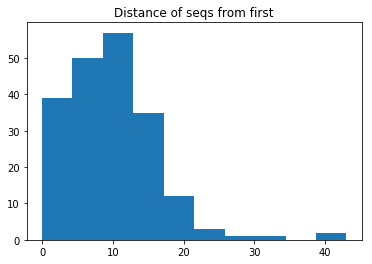

In [33]:
plt.hist(distance_from_0)
plt.title("Distance of seqs from first")
plt.show()

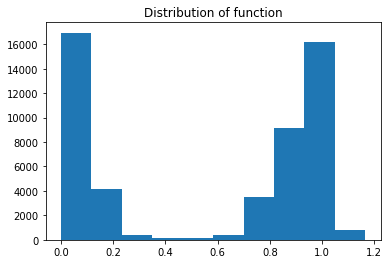

In [109]:
plt.hist(data_sar['quantitative_function'])
plt.title("Distribution of function")
plt.show()

In [37]:
from sklearn.decomposition import PCA

In [38]:
pca = PCA(n_components=2)
pca.fit(training_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [39]:
PCA_data_2dim = pca.transform(training_data)

In [40]:
PCA_data_2dim.transpose(1, 0)

array([[-1.18090053, -1.96169064, -2.00039794, -1.67802417, -1.64254703,
        -1.83611284, -1.8006357 , -1.92327704, -2.06124539, -1.96888396,
        -1.68812191, -1.691062  , -1.4273766 , -1.38303318, -2.29618087,
        -1.54654188, -2.18962714, -1.63888805, -2.00116194, -1.55170382,
        -2.22646824, -2.22131091, -1.38171609, -1.55170382, -2.05274388,
        -1.64489768, -0.3601301 , -1.55170382, -2.08205082, -1.6050953 ,
        -0.14740595, -1.6050953 , -1.18843776, -2.23559666, -1.18045133,
        -0.51909693, -0.87460532, -0.08365148, -1.24242899, -0.99184192,
        -0.92093747, -1.07722886,  0.22422219, -1.18000084,  0.03986184,
        -1.17883966, -1.15307023, -1.29563563, -1.2340641 , -0.92980376,
         0.16989753, -1.15356974, -1.03223134, -1.07627335, -1.08918771,
        -0.67028991,  0.75867852,  0.92107416, -2.15146424, -1.53190004,
        -1.094209  , -0.24387469, -1.08960811, -1.08960811, -1.08960811,
        -1.21592019, -1.08960811, -1.5320803 ,  0.2

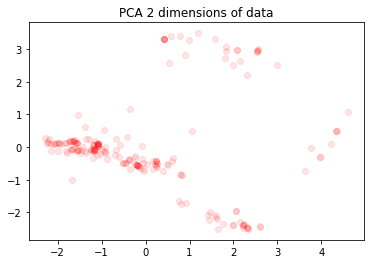

In [41]:
plt.scatter(PCA_data_2dim.transpose(1, 0)[0], PCA_data_2dim.transpose(1, 0)[1], alpha=0.1, color='r')
plt.title("PCA 2 dimensions of data")
plt.show()

## Baseline One-hot model

In [12]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components=5)
pca.fit(training_data)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [21]:
PCA_training_data = pca.transform(training_data)

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

In [27]:
#Classification on training data
data_sar['function'] = data_sar['quantitative_function'] > 0.5
X_train, X_test, y_train, y_test = train_test_split(training_data, data['function'], 
                                                   test_size = 0.3, random_state=10)

naiveClf = RandomForestClassifier()
naiveClf.fit(X_train, y_train)
naiveClf.score(X_test, y_test)

//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9205285207863358

In [29]:
X_train, X_test, y_train, y_test = train_test_split(training_data, data_sar['quantitative_function'], 
                                                   test_size = 0.3, random_state=10)

naiveReg = RandomForestRegressor()
naiveReg.fit(X_train, y_train)
naiveReg.score(X_test, y_test)

//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7445187384932194

In [30]:
X_train, X_test, y_train, y_test = train_test_split(PCA_training_data, data_sar['quantitative_function'], 
                                                   test_size = 0.3, random_state=10)

naiveReg = RandomForestRegressor()
naiveReg.fit(X_train, y_train)
naiveReg.score(X_test, y_test)

//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.029654035528665856

This concludes the pre-processing we need to do on the data.

## 2.  Training the model
We now move on to define our neural network. This is essentially a vanilla VAE in keras (with some optimization on hyperparameters). For optimization purposes we define a callback function that reports the predictive power of the model in the end of each epoch. Note that while this passes the -test data- through the model, it is kosher because we never pass in the values we are actually interested in and the network is not in "training phase", i.e. no weights are updated during this pass. 

In [49]:
class rho_vs_mutants():
    def __init__(self,mutants,test_set_size,aa_size,sequence_size):
        self.mutants=mutants
        self.sample_size=test_set_size
        self.aa_size=aa_size
        self.sequence_size=sequence_size
        self.scores=[]
        self.count_batch=0
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
    #This allows us to track the "progress" of the model on different epochs
    def on_epoch_end(self,model,batch,logs):
        x_decoded=model(test_data_plus[0:self.sample_size],batch_size=batch_size)
        digit = x_decoded[0].reshape(self.aa_size,self.sequence_size)
        digit_wt = normalize(digit,axis=0, norm='l1')
        wt_prob=compute_log_probability(digit,digit_wt)
        fitnesses=[]
        for sample in range(1,self.sample_size):
            digit = x_decoded[sample].reshape(self.aa_size,self.sequence_size)
            digit = normalize(digit,axis=0, norm='l1')
            fitness=compute_log_probability(test_data_plus[sample].reshape(self.aa_size,self.sequence_size),digit)-wt_prob
            fitnesses.append(fitness)
        print (","+str(spearmanr(fitnesses,target_values_singles[:self.sample_size-1])))
        self.scores.append(spearmanr(fitnesses,target_values_singles[:self.sample_size-1])[0])

Now we are ready to specify the network architecture, this is adapted from [here](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py).

In [50]:
# torch.sum(1 + model.z_log_var - (model.z_mean)**2 - torch.exp(model.z_log_var),-1)

In [51]:
PRUNED_SEQ_LENGTH

238

In [88]:
batch_size = 20
original_dim=len(ORDER_LIST)*PRUNED_SEQ_LENGTH
output_dim=len(ORDER_LIST)*PRUNED_SEQ_LENGTH
latent_dim = 2
intermediate_dim = 250
nb_epoch = 20
epsilon_std = 1.0
np.random.seed(42)  

loss1 = nn.CrossEntropyLoss()

def vae_loss(x_true, x_decoded_mean, z_mean, z_log_var):
    xent_loss = original_dim * loss1(x_decoded_mean, x_true)
    kl_loss = -0.5 * torch.sum(1 + z_log_var - (z_mean)**2 - torch.exp(z_log_var))
#     print ("xent loss: ", xent_loss)
#     print ("KL loss: ", kl_loss)
    return (xent_loss + kl_loss)

# #Encoding Layers
# x = Input(batch_shape=(batch_size, original_dim))
# h = Dense(intermediate_dim,activation="elu")(x)
# h= Dropout(0.7)(h)
# h = Dense(intermediate_dim, activation='elu')(h)
# h=BatchNormalization(mode=0)(h)
# h = Dense(intermediate_dim, activation='elu')(h)

# #Latent layers
# z_mean=Dense(latent_dim)(h)
# z_log_var=Dense(latent_dim)(h)
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# #Decoding layers 

# decoder_1= Dense(intermediate_dim, activation='elu')
# decoder_2=Dense(intermediate_dim, activation='elu')
# decoder_2d=Dropout(0.7)
# decoder_3=Dense(intermediate_dim, activation='elu')
# decoder_out=Dense(output_dim, activation='sigmoid')
# x_decoded_mean = decoder_out(decoder_3(decoder_2d(decoder_2(decoder_1(z)))))

# vae = Model(x, x_decoded_mean)

# #Potentially better results, but requires further hyperparameter tuning
# #optimizer=keras.optimizers.SGD(lr=0.005, momentum=0.001, decay=0.0, nesterov=False,clipvalue=0.05)
# vae.compile(optimizer="adam", loss=vae_loss,metrics=["categorical_accuracy","fmeasure","top_k_categorical_accuracy"])

And run it through our training data.

In [89]:
len(range(0, 300)[:20])

20

In [90]:
training_size = 200 #so batchingw orks
x_train=training_data[:200] #this needs to be divisible by batch size and less than or equal to dataset size
x_train = x_train.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

# early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# spearman_measure=rho_vs_mutants(test_data_plus,batch_size*int(len(test_data_plus)/batch_size),len(ORDER_LIST),PRUNED_SEQ_LENGTH)

In [91]:
vae_type = 'full'

In [92]:
if vae_type == 'rec':
    def vae_loss(x_true, x_decoded_mean, z_mean, z_log_var):
        xent_loss = x_true.shape[0]*loss1(x_decoded_mean, x_true)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - (z_mean)**2 - torch.exp(z_log_var))
        return (xent_loss + kl_loss), xent_loss, kl_loss

In [93]:
def conv_size_func(Lin,dilation,kernel,padding=0,stride=1):
  return int(((Lin+2*padding-dilation*(kernel-1)-1)/stride)+1)

In [94]:
if vae_type == 'full':
    print ("training on full")
    univ_dropout = [0.2]*3
    dropout_enc = univ_dropout
    dropout_dec = univ_dropout

    layers_enc = nn.ModuleList([nn.Linear(original_dim,intermediate_dim),nn.Dropout(dropout_enc[0]),nn.ELU()])
    for i in range(2):
        layers_enc.append(nn.Linear(intermediate_dim,intermediate_dim))
        layers_enc.append(nn.Dropout(dropout_enc[i+1]))
        layers_enc.append(nn.ELU())

    layers_dec = nn.ModuleList([nn.Linear(latent_dim,intermediate_dim),nn.Dropout(dropout_dec[0]),nn.ELU()])
    for i in range(2):
        layers_dec.append(nn.Linear(intermediate_dim,intermediate_dim))
        layers_dec.append(nn.Dropout(dropout_dec[i+1]))
        layers_dec.append(nn.ELU())

    layers_dec.append(nn.Linear(intermediate_dim,output_dim))

    layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])
elif vae_type == 'conv':
    out_conv_enc = [50,100]
    kernels_enc = [3,5]
    dilations_enc = [1,3]
    maxpools_enc = [4,3]
    paddings_enc = [(5,5,0,0)]
    
    out_lin_enc = [100,500]
    dropout_enc = [0.2,0.2]
    
    out_lin_dec = [100,150]
    dropout_dec = [0.2,0.2]
    
    layers_enc_pre_view = nn.ModuleList([nn.Conv1d(len(ORDER_LIST),out_conv_enc[0],kernels_enc[0],stride=1,dilation=dilations_enc[0]),
                                nn.ELU(),
                                nn.MaxPool1d(maxpools_enc[0],padding=0),
                                nn.ZeroPad2d(paddings_enc[0]),
                                nn.Conv1d(out_conv_enc[0],out_conv_enc[1],kernels_enc[1],stride=1,dilation=dilations_enc[1]),
                                nn.ELU(),
#                                 nn.MaxPool1d(4,padding=0),
#                                 nn.ZeroPad2d((5,5,0,0)),
#                                 nn.Conv1d(out_conv_enc[1],out_conv_enc[2],kernels_enc[2],stride=1,dilation=dilations_enc[2]),
#                                 nn.ELU(),
                                nn.MaxPool1d(maxpools_enc[1],padding=0)])
    
    inp_len = PRUNED_SEQ_LENGTH
    paddings_enc.append((0,0,0,0))
    for i in range(len(out_conv_enc)):
      inp_len = conv_size_func(inp_len,dilations_enc[i],kernels_enc[i])
      inp_len = inp_len//maxpools_enc[i]
      inp_len += (paddings_enc[i][0]+paddings_enc[i][1])
    
    enc_view = inp_len*out_conv_enc[-1]
    print('post-convolutional size is ', enc_view)
    
    layers_enc_post_view = nn.ModuleList([nn.Linear(enc_view,out_lin_enc[0]),
                                          nn.Dropout(dropout_enc[0]),
                                          nn.ELU(),
                                          nn.Linear(out_lin_enc[0],out_lin_enc[1]),
                                          nn.Dropout(dropout_enc[1]),
                                          nn.ELU()])
    
    layers_dec = nn.ModuleList([nn.Linear(latent_dim,out_lin_dec[0]),
                                nn.Dropout(dropout_dec[0]),
                                nn.ELU(),
                                nn.Linear(out_lin_dec[0],out_lin_dec[1]),
                                nn.Dropout(dropout_dec[1]),
                                nn.ELU(),
                                nn.Linear(out_lin_dec[1],output_dim)])
    
    layers_ae = nn.ModuleList([nn.Linear(out_lin_enc[-1],latent_dim),nn.Linear(out_lin_enc[-1],latent_dim)])
elif vae_type == 'rec':
    univ_dropout = [0.2]*2
    dropout_enc = univ_dropout
    dropout_dec = univ_dropout
    hid_size = [20,10]
    dec_lin = False
    
    num_layers = 2
    num_layers_dec = 2
    bid = True
    num_dirs = 2 if bid else 1
    
   
    layers_enc = nn.ModuleList([nn.RNN(len(ORDER_LIST),hid_size[0],num_layers=num_layers,batch_first=True,dropout=univ_dropout[0],bidirectional=bid)])


    if dec_lin:
      layers_post_rec_enc = nn.ModuleList([nn.Linear(164,intermediate_dim),
                                         nn.Dropout(dropout_enc[0]),
                                         nn.ELU(),
                                         nn.Linear(intermediate_dim,intermediate_dim),
                                         nn.Dropout(dropout_enc[1]),
                                         nn.ELU()]) # for now, not being used in rec model


  #     layers_pre_rec_dec = nn.ModuleList([nn.Linear(latent_dim,100),
  #                                         nn.Dropout(dropout_dec[0]),
  #                                         nn.ELU()])
  #     # 25 below bc bidirectional 2 layers means we have to divide 100 by 2*2
  #     layers_dec = nn.ModuleList([nn.RNN(50,25,num_layers=2,batch_first=True,dropout=0.2,bidirectional=True)])
  #     layers_post_rec_dec = nn.ModuleList([nn.Linear(25*2,len(ORDER_LIST))])

  #     layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])
      layers_dec = nn.ModuleList([nn.Linear(latent_dim,intermediate_dim),
                                  nn.Dropout(.2),
                                  nn.ELU(),
                                  nn.Linear(intermediate_dim,intermediate_dim*2),
                                  nn.Dropout(.2),
                                  nn.ELU(),
                                  nn.Linear(intermediate_dim*2,output_dim)])
      
      layers_dec_post_rec = 0
    
      layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])
    
    else: # dec_lin = False
      layers_post_rec_enc = 0
      
      layers_dec = nn.ModuleList([nn.Linear(latent_dim,hid_size[1]),nn.RNN(len(ORDER_LIST),hid_size[1],num_layers=num_layers_dec,batch_first=True,dropout=univ_dropout[1],bidirectional=bid)])
      
      layers_dec_post_rec = nn.ModuleList([nn.Linear(hid_size[1]*num_dirs,len(ORDER_LIST))])
      
      layers_ae = nn.ModuleList([nn.Linear(hid_size[0],latent_dim),nn.Linear(hid_size[0],latent_dim)])
      
      

training on full


In [95]:
losses_train = []
losses_test = []
accuracies_train = []
accuracies_test = []
xents_train = []
xents_test = []
kls_train = []
kls_test = []

if vae_type == 'full':
    print ("training full")
    model = VAE(layers_enc,layers_ae,layers_dec)

    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.001)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)

    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,len(ORDER_LIST)*PRUNED_SEQ_LENGTH) # 1968)

        train = torch.Tensor(train)

        
        
        for batch in train:
            out = model(batch)

            batch = batch.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss = vae_loss(batch,out,model.z_mean,model.z_log_var)
            
            optimizer.zero_grad()
            loss.backward()  
            optimizer.step()
            
        model.eval()

        out_train = model(torch.Tensor(x_train_data))
        out_train = torch.Tensor(out_train)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(torch.Tensor(x_val_data))
        out_val = torch.Tensor(out_val)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)
        
        losses_train.append(loss_train)
        losses_test.append(loss_val)
        accuracies_train.append(class_acc_train)
        accuracies_test.append(class_acc_val)
        
        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )

elif vae_type == 'conv':
    print ("conv")
    model = VAE_conv(layers_enc_pre_view,enc_view,layers_enc_post_view,layers_ae,layers_dec)
        
    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.001)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)

    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        train = torch.Tensor(train)
        train = train.transpose(-2,-1)

        for batch in train:
            out = model(batch)

            batch = batch.transpose(-2,-1).reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
                            
            loss = vae_loss(batch,out,model.z_mean,model.z_log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        out_train = model(torch.Tensor(x_train_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)).transpose(-2,-1))
        out_train = torch.Tensor(out_train)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(torch.Tensor(x_val_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)).transpose(-2,-1))
        out_val = torch.Tensor(out_val)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)

        losses_train.append(loss_train)
        losses_test.append(loss_val)
        accuracies_train.append(class_acc_train)
        accuracies_test.append(class_acc_val)
        
        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )
        
elif vae_type == 'rec':
    print ("rec")
    if lang_mod:
        print("language model training")
    else:
        print("vae training")
    
    alpha = 50000
    beta = 0.005
    print('KL annealing terms: alpha = {}, beta = {}'.format(alpha,beta))
        
    model = VAE_rec(layers_enc,layers_post_rec_enc,layers_ae,0,layers_dec,layers_dec_post_rec)
    
    if cuda:
        model = model.cuda()
    
    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.01)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)
    
#     print('FAKE TRAINING SET TO ASSESS REC VALIDITY')
#     x_train_data = np.array([[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]*3690000).reshape(45000,1968)
    
#     import pdb; pdb.set_trace()
    
    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)
    
    ins_train = create_tensor(ins_train,gpu=cuda)
    ins_val = create_tensor(ins_val,gpu=cuda)
    
    
    ## Printing model perf before
    model.eval()
            
    out_train = model(create_tensor(torch.Tensor(x_train_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
    out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

    classpreds_train = torch.argmax(out_train,dim=1)
    bool_train = (classpreds_train==ins_train)
    class_acc_train = bool_train.sum().item()/bool_train.shape[0]

    out_val = model(create_tensor(torch.Tensor(x_val_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
    out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

    classpreds_val = torch.argmax(out_val,dim=1)
    bool_val = (classpreds_val==ins_val)
    class_acc_val = bool_val.sum().item()/bool_val.shape[0]

    loss_train,xent_train,kl_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
    kl_train = sigmoid(beta*(-alpha))*kl_train # annealing
    loss_train = xent_train + kl_train # annealing
    loss_val,xent_val,kl_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)
    kl_val = sigmoid(beta*(-alpha))*kl_val # annealing
    loss_val = xent_val + kl_val # annealing

    losses_train.append(loss_train.item())
    losses_test.append(loss_val.item())
    accuracies_train.append(class_acc_train)
    accuracies_test.append(class_acc_val)
    xents_train.append(xent_train.item())
    xents_test.append(xent_val.item())
    kls_train.append(kl_train.item())
    kls_test.append(kl_val.item())

    print('Pre-training | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
          %( loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )
    
    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        train = create_tensor(torch.Tensor(train),gpu=cuda)

        xents = []
        kls = []
        
        num_dum = -1

        optimizer.zero_grad()
        
        for batch in train:
            num_dum += 1
            out = model(batch,True,lang_mod)
            
#             import pdb; pdb.set_trace()
            batch = torch.argmax(batch,-1)
            batch = batch.reshape(-1)
                        
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss,xent,kl = vae_loss(batch,out,model.z_mean,model.z_log_var)
            mult = epoch*len(x_train_data)/batch_size + num_dum # annealing
            kl = sigmoid(beta*(mult-alpha))*kl # annealing
            loss = xent + kl # annealing
            if num_dum % 1000 == 0:
                print((batch==torch.argmax(out,-1)).sum().item()/(batch_size*PRUNED_SEQ_LENGTH*1.0))
            xents.append(xent)
            kls.append(kl)

            if lang_mod:
                xent.backward()
            else:
                loss.backward()   
            
#         for layer, paramval in model.named_parameters():
#             print(layer,paramval.grad)
            
        optimizer.step()
            
#         import pdb; pdb.set_trace()
        print('xent mean is:',torch.stack(xents).mean().item())
        print('kl mean is:',torch.stack(kls).mean().item())

        model.eval()
        
#         import pdb; pdb.set_trace()
        out_train = model(create_tensor(torch.Tensor(x_train_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(create_tensor(torch.Tensor(x_val_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train,xent_train,kl_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        mult = epoch*len(x_train_data)/batch_size + num_dum # annealing
        kl_train = sigmoid(beta*(mult-alpha))*kl_train # annealing
        loss_train = xent_train + kl_train # annealing
        loss_val,xent_val,kl_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)
        kl_val = sigmoid(beta*(mult-alpha))*kl_val # annealing
        loss_val = xent_val + kl_val # annealing
        
        losses_train.append(loss_train.item())
        losses_test.append(loss_val.item())
        accuracies_train.append(class_acc_train)
        accuracies_test.append(class_acc_val)
        xents_train.append(xent_train.item())
        xents_test.append(xent_val.item())
        kls_train.append(kl_train.item())
        kls_test.append(kl_val.item())
        
        print(classpreds_train)
        print(classpreds_val)
        
        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )

training full
Epoch 0 | Training Loss: 2965.04833984375, Training Accuracy: 0.951750700280112, Validation Loss: 2809.42529296875, Validation Accuracy: 0.9512605042016806
Epoch 1 | Training Loss: 1098.9971923828125, Training Accuracy: 0.9575163398692811, Validation Loss: 1447.534423828125, Validation Accuracy: 0.9586134453781513
Epoch 2 | Training Loss: 887.9511108398438, Training Accuracy: 0.9602240896358544, Validation Loss: 761.9097290039062, Validation Accuracy: 0.9594537815126051
Epoch 3 | Training Loss: 738.9840698242188, Training Accuracy: 0.9582166199813259, Validation Loss: 664.9811401367188, Validation Accuracy: 0.9602941176470589
Epoch 4 | Training Loss: 758.4254150390625, Training Accuracy: 0.9598506069094305, Validation Loss: 669.6949462890625, Validation Accuracy: 0.9615546218487395
Epoch 5 | Training Loss: 746.3814086914062, Training Accuracy: 0.9601073762838469, Validation Loss: 625.1912231445312, Validation Accuracy: 0.9588235294117647
Epoch 6 | Training Loss: 748.32775

Let's explore the latent space

In [96]:
fit_xtrain = model(torch.Tensor(x_train)).detach()
z_means = model.z_mean.detach()

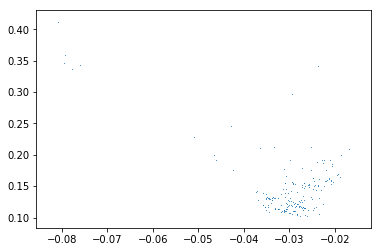

In [97]:
transposed_zmeans = np.array(z_means).transpose()

plt.scatter(transposed_zmeans[0], transposed_zmeans[1], s = 1, linewidths = 0)
plt.show()

In [98]:
from sklearn.cluster import KMeans

z_means_np = np.array(z_means)
kmeans = KMeans(n_clusters=12, random_state=1).fit(z_means_np)

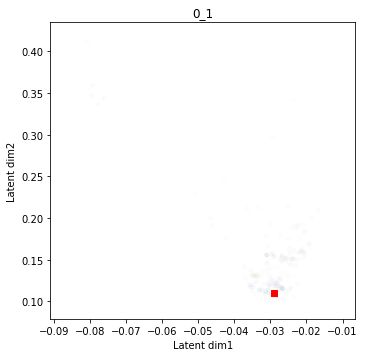

In [99]:
sample_points=len(z_means_np)

latent_dim = 2
fig = plt.figure(figsize=(12,12))
counter=0
cmap=kmeans.labels_
for z1 in range(latent_dim):
    for z2 in range(z1+1,latent_dim):
        counter+=1
        fig.add_subplot(latent_dim,latent_dim,counter)
        plt.title(str(z1)+"_"+str(z2))
        plt.scatter(z_means_np[:, z1][::-1], z_means_np[:, z2][::-1],c=cmap[::-1], s = 15, alpha=0.01,marker="o")
#         plt.scatter(z_means_np[:, z1][::-1], z_means_np[:, z2][::-1],c="y" ,alpha=0.3,marker="o")
        plt.scatter(z_means_np[0][z1], z_means_np[0][z2],c="r" ,alpha=1,s=40,marker="s")
        plt.xlabel("Latent dim"+str(z1+1))
        plt.ylabel("Latent dim"+str(z2+1));
plt.savefig("Try2_originalDropout.png")


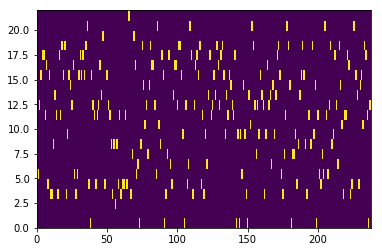

In [103]:
plt.pcolor(x_train[0].reshape(-1, len(ORDER_LIST)).transpose(1, 0))
plt.show()

# Training a classifier over the latent space

In [104]:
fit_total = model(torch.Tensor(training_data)).detach()
latent_data = model.z_mean.detach()

In [105]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

In [106]:
X_train, X_test, y_train, y_test = train_test_split(np.array(latent_data), data_sar['quantitative_function'], 
                                                   test_size = 0.3, random_state=10)

KeyError: 'quantitative_function'

In [52]:
latentReg = RandomForestRegressor()
latentReg.fit(X_train, y_train)
# latentReg.predict(X_test)
latentReg.score(X_test, y_test)

//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.22836945948961562

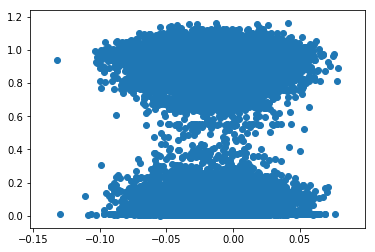

In [63]:
plt.scatter(X_train[:,0], y_train)
plt.show()

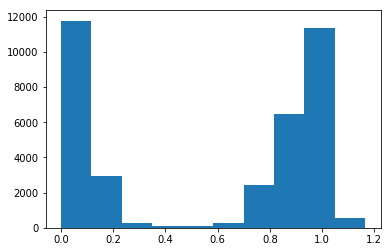

In [38]:
plt.hist(y_train)
plt.show()

In [54]:
np.sum(data['function'])/len(data)

0.5817461084791646

In [53]:
data['function'] = data['quantitative_function'] > 0.5

X_train, X_test, y_train, y_test = train_test_split(np.array(latent_data), data['function'], 
                                                   test_size = 0.3, random_state=10)

latentClf = RandomForestClassifier()
latentClf.fit(X_train, y_train)
# latentReg.predict(X_test)
latentClf.score(X_test, y_test)

//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7218175958749597

In [48]:
# reshaped_fit_xtrain = fit_xtrain.reshape(len(x_train)*len(ORDER_LIST),PRUNED_SEQ_LENGTH)
m = torch.nn.Softmax()

reshaped_fit_xtrain = m(fit_xtrain.reshape(51700 * 238, 24)).reshape(51700, 238, 24).transpose(2, 1)

# m = torch.nn.Sigmoid()

# reshaped_fit_xtrain = torch.stack(list(map(m, fit_xtrain))).reshape(50000, 82, 24).transpose(2, 1)

//anaconda/envs/ML_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [ ]:
plt.pcolor(reshaped_fit_xtrain[0])

In [ ]:
plt.pcolor(np.matmul(test_data_plus[0].reshape(digit_size, sequence_size).T, digit_wt))

In [52]:
# sample_size=batch_size*int(len(test_data_plus)/batch_size)
sample_size = batch_size*int(len(x_train)/batch_size)
sample_for_averging_size=100
sequence_size=PRUNED_SEQ_LENGTH
digit_size = len(ORDER_LIST)
x_decoded=reshaped_fit_xtrain






wt_prob=compute_log_probability(x_train[0].reshape(digit_size, sequence_size),digit_wt)
#print ("wt_log_prob: ", wt_prob)

wt_probs=[]
digit_avg=np.zeros((digit_size, sequence_size))


sample_indices=random.sample(range(sample_size),sample_for_averging_size)

counter=0
for sample in sample_indices:
    digit = x_decoded[sample]
#     print (digit)
#     print (digit_avg)
#     digit_wt_i = normalize(digit,axis=0, norm='l1')
    digit_wt_i = digit
    
#     print (digit_wt_i)
    
    digit_avg+=np.array(digit_wt_i) * 1. / sample_for_averging_size
    
    wt_p=compute_log_probability(x_train[sample].reshape(digit_size, sequence_size),digit_wt_i)
    wt_probs.append(wt_p)
    counter+=1
    
average_wt_p=np.mean(wt_probs)

fitnesses_vs_wt=[]
fitnesses=[] #first plug in just the sequences
fitnesses_vs_avg=[] 

for sample in range(1,sample_size):
    digit = x_decoded[sample]
#     digit = normalize(digit,axis=0, norm='l1')
    
    fitness=compute_log_probability(x_train[sample].reshape(digit_size, sequence_size),digit)-wt_prob
    fitnesses.append(fitness)
    
    fitness=compute_log_probability(x_train[sample].reshape(digit_size, sequence_size),digit_wt)-wt_prob
    fitnesses_vs_wt.append(fitness)
    
    fitness=compute_log_probability(x_train[sample].reshape(digit_size, sequence_size),digit_avg)-average_wt_p
    fitnesses_vs_avg.append(fitness)
    
    
# print ("Spearman",spearmanr(fitnesses_vs_wt,target_values_singles[:sample_size-1]))
# print ("Pearson", pearsonr(fitnesses_vs_wt,target_values_singles[:sample_size-1]))

/Users/DavidKMYang/Spring2019_Harvard/Math243/VAE_protein_function/helper_tools.py:103: RuntimeWarning: divide by zero encountered in log
  log_prod_mat=np.log(prod_mat)
//anaconda/envs/ML_env/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in subtract
//anaconda/envs/ML_env/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/envs/ML_env/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
plt.pcolor(test_data_plus[0].reshape(digit_size, sequence_size))

In [ ]:
plt.pcolor(digit_wt)

In [ ]:
spearmanr(fitnesses_vs_avg, fitnesses)

In [ ]:
plt.scatter(fitnesses_vs_wt, target_values_singles[:sample_size-1], alpha = 0.5, s = 10)
plt.ylabel("Fitness vs. wt")
plt.xlabel("p(x)")
plt.title(spearmanr(fitnesses_vs_wt, target_values_singles[:sample_size-1]))
plt.tight_layout()
plt.savefig("Correlation.png")
plt.show()


In [ ]:
plt.scatter(fitnesses_vs_wt, target_values_singles[:sample_size-1], alpha = 0.5, s = 10)
plt.show()

In [ ]:
plt.hist(fitnesses,bins=30)
plt.show()

In [ ]:
plt.hist(target_values_singles[:sample_size-1], bins=50)
plt.show()

We have kept track of some performance metrics, so we can follow whether the network was still improving. 